**Basically same notebook as the one used in round 3. I just reran some cells with round 4 data to update params**

## Helper functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

voucher_names = [
        "VOLCANIC_ROCK_VOUCHER_9500",
        "VOLCANIC_ROCK_VOUCHER_9750",
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250",
        "VOLCANIC_ROCK_VOUCHER_10500",
    ]

volcanic_products = [ 
    'VOLCANIC_ROCK',
    'VOLCANIC_ROCK_VOUCHER_9500',
    'VOLCANIC_ROCK_VOUCHER_9750',
    'VOLCANIC_ROCK_VOUCHER_10000',
    'VOLCANIC_ROCK_VOUCHER_10250',
    'VOLCANIC_ROCK_VOUCHER_10500',
]

def plot_product_mid_prices(csv_file_path: str, ignore_old: bool = True):
    try:
        df = pd.read_csv(csv_file_path, delimiter=';')

        # Convert relevant cols to numeric
        df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
        df['mid_price'] = pd.to_numeric(df['mid_price'], errors='coerce')

        # Drop rows where data is missing after conversion, if any
        df.dropna(subset=['timestamp', 'mid_price', 'product'], inplace=True)

        # Get all unique product
        all_products = df['product'].unique()

        # Products to ignore
        products_to_ignore = {"KELP", "RAINFOREST_RESIN", "SQUID_INK"} 

        # Filter the product list based on the ignore_old flag
        if ignore_old:
            products_to_plot = [p for p in all_products if p not in products_to_ignore]
        else:
            products_to_plot = list(all_products) # Plot all products

        num_products_to_plot = len(products_to_plot)

        # Check if there are any products left to plot
        if num_products_to_plot == 0:
            print("No products to plot")
            return

        # Create the figure and the exact number of subplots required
        fig, axes = plt.subplots(nrows=num_products_to_plot, ncols=1, sharex=True,
                                 figsize=(12, 4 * num_products_to_plot), squeeze=False)
        axes = axes.flatten()

        # Iterate through products 
        for i, product in enumerate(products_to_plot):
            ax = axes[i] # Select the correct subplot axis

            # Filter the DataFrame for the current product's data
            product_df = df[df['product'] == product].sort_values('timestamp')

            # Plot mid_price vs timestamp for this product
            ax.plot(product_df['timestamp'], product_df['mid_price'], label=product)

            # Set the title and y-axis label for this subplot
            ax.set_title(f'{product} Mid Price')
            ax.set_ylabel('Mid Price')
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
            ax.grid(True, linestyle='--', alpha=0.6)
            
             
        # Set the x-axis label only on the bottom-most subplot
        axes[-1].set_xlabel('Timestamp')
        plt.tight_layout() 
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")

def plot_volcanic_products(csv_path, volcanic_products):
    df = pd.read_csv(csv_path, sep=";")

    volcanic_products = volcanic_products

    # Filter only volcanic products
    df_volcanic = df[df['product'].isin(volcanic_products)]

    # Create subplots
    num_products = len(volcanic_products)
    fig, axes = plt.subplots(num_products, 1, figsize=(12, 3 * num_products), sharex=True)

    for i, product in enumerate(volcanic_products):
        product_df = df_volcanic[df_volcanic['product'] == product]
        axes[i].plot(product_df['timestamp'], product_df['mid_price'], label=product, color='orange')
        axes[i].set_ylabel("Mid Price")
        axes[i].set_title(f"Mid Price Time Series: {product}")
        axes[i].legend(loc="upper left")
        axes[i].grid(True)

    axes[-1].set_xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

strike_prices = { # for processing function
    'VOLCANIC_ROCK_VOUCHER_9500': 9500,
    'VOLCANIC_ROCK_VOUCHER_9750': 9750,
    'VOLCANIC_ROCK_VOUCHER_10000': 10000,
    'VOLCANIC_ROCK_VOUCHER_10250': 10250,
    'VOLCANIC_ROCK_VOUCHER_10500': 10500,
}

def process_volcanic_day(df):
    # Filter only volcanic products
    df = df[df["product"].isin(volcanic_products)].copy()

    # Merge to get volcanic rock mid_price for each timestamp
    rock_prices = df[df["product"] == "VOLCANIC_ROCK"][["day", "timestamp", "mid_price"]].rename(columns={"mid_price": "rock_mid"})
    
    enriched_dfs = []

    for voucher, strike in strike_prices.items():
        df_voucher = df[df["product"] == voucher].copy()

        # Merge rock mid price into voucher df
        df_voucher = df_voucher.merge(rock_prices, on=["day", "timestamp"], how="left")

        # Calculate intrinsic value 
        df_voucher["intrinsic_value"] = (df_voucher["rock_mid"] - strike).clip(lower=0)
        enriched_dfs.append(df_voucher)

    # Combine all vouchers + rock
    final_df = pd.concat(enriched_dfs + [df[df["product"] == "VOLCANIC_ROCK"]], ignore_index=True)
    return final_df

def plot_rock_and_intrinsic_values(df, voucher_names):
    fig, axes = plt.subplots(6, 1, figsize=(14, 18), sharex=True)

    # Plot VOLCANIC_ROCK mid_price
    rock_df = df[df["product"] == "VOLCANIC_ROCK"]
    axes[0].plot(rock_df["timestamp"], rock_df["mid_price"], label="VOLCANIC_ROCK", color="black")
    axes[0].set_title("Mid Price of VOLCANIC_ROCK")
    axes[0].set_ylabel("Mid Price")
    axes[0].legend()

    voucher_names = voucher_names

    for i, voucher in enumerate(voucher_names):
        voucher_df = df[df["product"] == voucher]
        axes[i + 1].plot(voucher_df["timestamp"], voucher_df["intrinsic_value"], label="Intrinsic Value", linestyle='--')
        axes[i + 1].plot(voucher_df["timestamp"], voucher_df["mid_price"], label="Voucher Mid Price", alpha=0.8)
        axes[i + 1].set_title(f"{voucher}")
        axes[i + 1].set_ylabel("Price")
        axes[i + 1].legend()

    axes[-1].set_xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

## Black-Scholes Formula

The code below is originally from a 2024 notebook to analyze the coconut coupon.   
I adapted it to work with the current products :-)  
What we do here is calculate the Black Scholes value for each voucher and plotting it against the midprice

Credits to https://github.com/Luka-R-Lukacevic/prosperity2/blob/main/round_04/research.ipynb



In [23]:
filename_1 = r'./data/2025/round4/prices_round_4_day_1.csv'
filename_2 = r'./data/2025/round4/prices_round_4_day_2.csv'
filename_3 = r'./data/2025/round4/prices_round_4_day_3.csv'

product_1 = "VOLCANIC_ROCK"
product_2 = "VOLCANIC_ROCK_VOUCHER_9500"
product_3 = "VOLCANIC_ROCK_VOUCHER_9750"
product_4 = "VOLCANIC_ROCK_VOUCHER_10000"
product_5 = "VOLCANIC_ROCK_VOUCHER_10250"
product_6 = "VOLCANIC_ROCK_VOUCHER_10500"


file_1 = pd.read_csv(filename_1, sep=';')  
file_1_coupon1 = file_1[file_1['product'] == product_2]
file_1_coupon2 = file_1[file_1['product'] == product_3]
file_1_coupon3 = file_1[file_1['product'] == product_4]
file_1_coupon4 = file_1[file_1['product'] == product_5]
file_1_coupon5 = file_1[file_1['product'] == product_6]
file_1 = file_1[file_1['product'] == product_1]

file_2 = pd.read_csv(filename_2, sep=';')  
file_2_coupon1 = file_2[file_2['product'] == product_2]
file_2_coupon2 = file_2[file_2['product'] == product_3]
file_2_coupon3 = file_2[file_2['product'] == product_4]
file_2_coupon4 = file_2[file_2['product'] == product_5]
file_2_coupon5 = file_2[file_2['product'] == product_6]
file_2 = file_2[file_2['product'] == product_1]

file_3 = pd.read_csv(filename_3, sep=';')  
file_3_coupon1 = file_3[file_3['product'] == product_2]
file_3_coupon2 = file_3[file_3['product'] == product_3]
file_3_coupon3 = file_3[file_3['product'] == product_4]
file_3_coupon4 = file_3[file_3['product'] == product_5]
file_3_coupon5 = file_3[file_3['product'] == product_6]
file_3 = file_3[file_3['product'] == product_1]

data = pd.concat([file_1, file_2, file_3])  ## Three days merged into 1 frame
data_coupon1 = pd.concat([file_1_coupon1, file_2_coupon1, file_3_coupon1]) # Merge coupon (voucher) data
data_coupon2 = pd.concat([file_1_coupon2, file_2_coupon2, file_3_coupon2])
data_coupon3 = pd.concat([file_1_coupon3, file_2_coupon3, file_3_coupon3])
data_coupon4 = pd.concat([file_1_coupon4, file_2_coupon4, file_3_coupon4])
data_coupon5 = pd.concat([file_1_coupon5, file_2_coupon5, file_3_coupon5])

df = pd.DataFrame()

mid_price_product_1 = data['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_2 = data_coupon1['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_3 = data_coupon2['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_4 = data_coupon3['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_5 = data_coupon4['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_6 = data_coupon5['mid_price'].reset_index().drop('index', axis=1)

mid_price_product_1['log_return'] = np.log(mid_price_product_1['mid_price']) - np.log(mid_price_product_1['mid_price'].shift(1))
sigma = mid_price_product_1['log_return'].std() * np.sqrt(252)  # annualized volatility
print("SIGMA: ", sigma)

SIGMA:  0.003788695043364419


In [ ]:
import math

def norm_cdf(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def black_scholes_call(S, X, T, r, sigma):
    d1 = (math.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    N_d1 = norm_cdf(d1)
    N_d2 = norm_cdf(d2)
    call_price = S * N_d1 - X * math.exp(-r * T) * N_d2
    return call_price, N_d1

r = 0.0  # No interest rate (in 2024 they also used 0.0)
T = 4 / 365  # DTE
'From WIKI: At beginning of Round 1, all the Vouchers have 7 trading days to expire. '
'By end of Round 5, vouchers will have 2 trading days left to expire.'
'--> We are in round 3 now, so 4 days left to expire'

'--> We are in round 3 now, so 4 days left to expire'

In [25]:
mid_price_product_2['bs_value'] = np.nan # voucher 9500
mid_price_product_2['bs_delta'] = np.nan
mid_price_product_3['bs_value'] = np.nan # voucher 9750
mid_price_product_3['bs_delta'] = np.nan
mid_price_product_4['bs_value'] = np.nan # voucher 10000
mid_price_product_4['bs_delta'] = np.nan
mid_price_product_5['bs_value'] = np.nan # voucher 10250
mid_price_product_5['bs_delta'] = np.nan
mid_price_product_6['bs_value'] = np.nan # voucher 10500
mid_price_product_6['bs_delta'] = np.nan

0.4289285856020873


<Axes: >

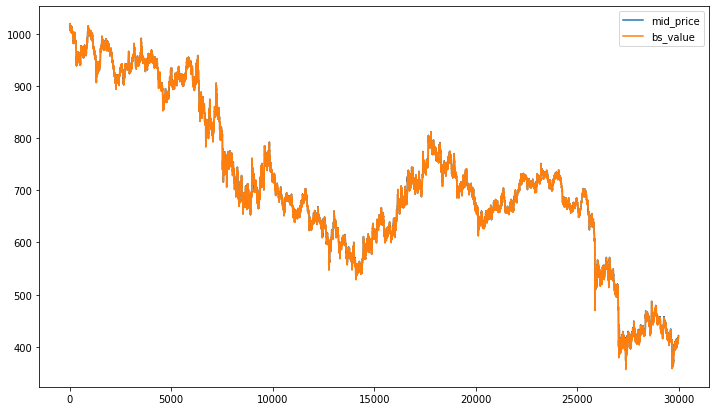

In [26]:
X = 9500  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_2['bs_value'].iloc[idx], mid_price_product_2['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_2['price_diff'] = mid_price_product_2['mid_price'] - mid_price_product_2['bs_value']
print(mid_price_product_2['price_diff'].std())

mid_price_product_2[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_2[['bs_delta']].plot(figsize=[12, 7])

4.079712058536923


<Axes: >

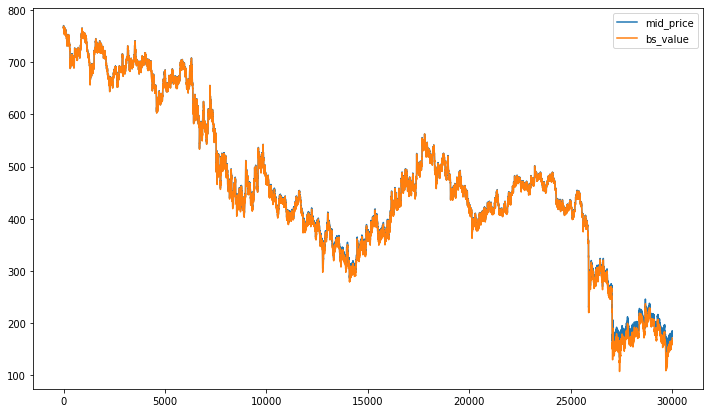

In [27]:
X = 9750  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_3['bs_value'].iloc[idx], mid_price_product_3['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_3['price_diff'] = mid_price_product_3['mid_price'] - mid_price_product_3['bs_value']
print(mid_price_product_3['price_diff'].std())

mid_price_product_3[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_3[['bs_delta']].plot(figsize=[12, 7])

14.571844452478892


<Axes: >

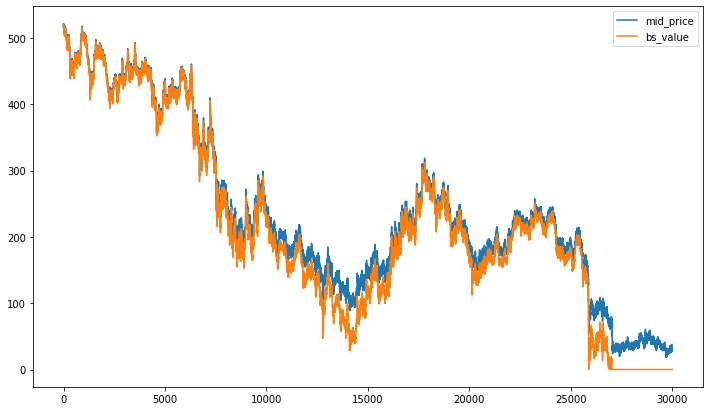

In [28]:
X = 10000  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_4['bs_value'].iloc[idx], mid_price_product_4['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_4['price_diff'] = mid_price_product_4['mid_price'] - mid_price_product_4['bs_value']
print(mid_price_product_4['price_diff'].std())

mid_price_product_4[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_4[['bs_delta']].plot(figsize=[12, 7])

19.304619990968458


<Axes: >

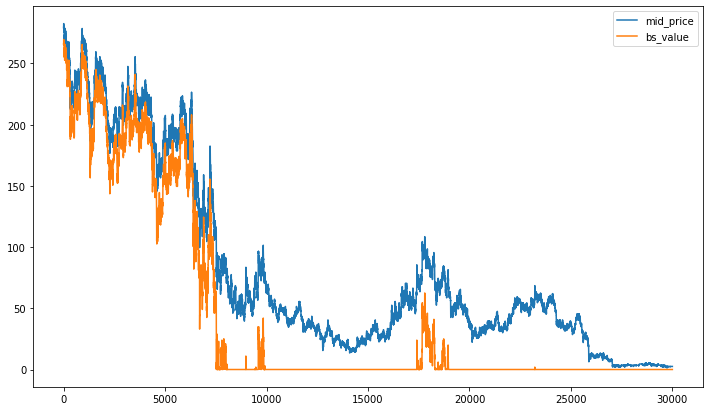

In [29]:
X = 10250  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_5['bs_value'].iloc[idx], mid_price_product_5['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_5['price_diff'] = mid_price_product_5['mid_price'] - mid_price_product_5['bs_value']
print(mid_price_product_5['price_diff'].std())

mid_price_product_5[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_5[['bs_delta']].plot(figsize=[12, 7])

23.528264675476393


<Axes: >

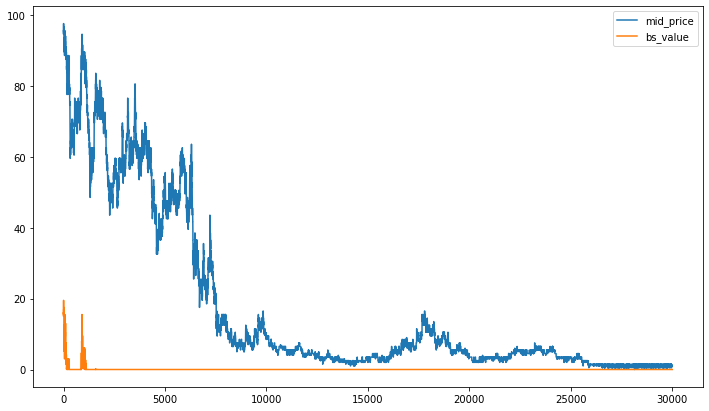

In [30]:
X = 10500  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_6['bs_value'].iloc[idx], mid_price_product_6['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_6['price_diff'] = mid_price_product_6['mid_price'] - mid_price_product_6['bs_value']
print(mid_price_product_6['price_diff'].std())

mid_price_product_6[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_6[['bs_delta']].plot(figsize=[12, 7])

**How to use BS?**  
So this is what that a 2024 team did (https://github.com/davidteather/imc-prosperity-2024/blob/main/main.py):

Alright so this strategy models the fair value of the coconutvoucher using the BS formula. It assumes the underlying asset is the mid-price of COCONUT.  

Vars:  
	•	Strike Price: 10000 (saw this in their main.py).  
	•	Maturity: Remaining days until expiry.  
	•	Risk-Free Rate: Assumed to be zero.  
	•	Volatility: Estimated dynamically using Exponentially Weighted Moving Average (EWMA) of historical returns.

Trading Logic:    
	1.	Update Volatility: Using past rock prices and EWMA. (In their main.py they also set a max log limit - 3750 - probably to make sure it doesn't become too large, cuz that slows down execution)  
	2.	Compute Theoretical Price: Via the BS formula.  
	3.	Buy the coupon if its ask price is below the theoretical price.  
	4.	Sell the coupon if its bid price is above the theoretical price.  

The strategy assumes a mispricing opportunity exists between the market price and theoretical value of the coupon.

Think this is a decent strategy to use.  
Here is another example we could look at: https://github.com/Luka-R-Lukacevic/prosperity2/blob/main/round_04/round_04_jannik.py

## Baskets Spreads and Standard Div calculation
Needed for new trading logic (adapted from Linear Utility Team!)

In [33]:
day = 0
file_name = f"./data/2025/round4/prices_round_4_day_3.csv"
df = pd.read_csv(file_name, sep=';')

BASKET1_WEIGHTS = {
    "JAMS": 3,
    "CROISSANTS": 6,
    "DJEMBES": 1,
}
BASKET2_WEIGHTS = {
    "JAMS": 4,
    "CROISSANTS": 2,
}
BASKET1_NAME = "PICNIC_BASKET1"
BASKET2_NAME = "PICNIC_BASKET2"

def compute_swmid(df):
    return (df['bid_price_1'] * df['ask_volume_1'] + df['ask_price_1'] * df['bid_volume_1']) / (
        df['ask_volume_1'] + df['bid_volume_1']
    )

df_components1 = {}
for product in BASKET1_WEIGHTS:
    df_product = df[df['product'] == product].copy()
    df_product['swmid'] = compute_swmid(df_product)
    df_components1[product] = df_product

synthetic1 = sum(df_components1[product]['swmid'].values * weight for product, weight in BASKET1_WEIGHTS.items())
df_synth1 = pd.DataFrame({
    "timestamp": df_components1["JAMS"]['timestamp'],
    "synthetic_price": synthetic1
})
df_basket1 = df[df['product'] == BASKET1_NAME].copy()
df_basket1['swmid'] = compute_swmid(df_basket1)
df_synth1['basket_price'] = df_basket1['swmid'].values
df_synth1['spread'] = df_synth1['basket_price'] - df_synth1['synthetic_price']

print("== PICNIC_BASKET1 ==")
print(f"Spread Mean: {df_synth1['spread'].mean():.4f}")
print(f"Spread Std: {df_synth1['spread'].std():.4f}")


df_components2 = {}
for product in BASKET2_WEIGHTS:
    df_product = df[df['product'] == product].copy()
    df_product['swmid'] = compute_swmid(df_product)
    df_components2[product] = df_product

synthetic2 = sum(df_components2[product]['swmid'].values * weight for product, weight in BASKET2_WEIGHTS.items())
df_synth2 = pd.DataFrame({
    "timestamp": df_components2["JAMS"]['timestamp'],
    "synthetic_price": synthetic2
})
df_basket2 = df[df['product'] == BASKET2_NAME].copy()
df_basket2['swmid'] = compute_swmid(df_basket2)
df_synth2['basket_price'] = df_basket2['swmid'].values
df_synth2['spread'] = df_synth2['basket_price'] - df_synth2['synthetic_price']

print("\n== PICNIC_BASKET2 ==")
print(f"Spread Mean: {df_synth2['spread'].mean():.4f}")
print(f"Spread Std: {df_synth2['spread'].std():.4f}")

== PICNIC_BASKET1 ==
Spread Mean: -96.6219
Spread Std: 73.4100

== PICNIC_BASKET2 ==
Spread Mean: -4384.7189
Spread Std: 78.5914


DAY 1:  
== PICNIC_BASKET1 ==
Spread Mean: 32.3571
Spread Std: 89.1617

== PICNIC_BASKET2 ==
Spread Mean: -4473.6023
Spread Std: 67.2463

DAY 2:    
== PICNIC_BASKET1 ==
Spread Mean: 96.6960
Spread Std: 79.2531

== PICNIC_BASKET2 ==
Spread Mean: -4467.7633
Spread Std: 58.8960

DAY 3:

== PICNIC_BASKET1 ==
Spread Mean: -96.6219
Spread Std: 73.4100

== PICNIC_BASKET2 ==
Spread Mean: -4384.7189
Spread Std: 78.5914



In [ ]:
mean_spread_b1 = (43.9225 + 32.3571 + 96.6960) / 3
mean_std_b1 = (82.7889 + 89.1617 + 79.2531) / 3

mean_spread_b2 = (0 - 4587.8086 - 4473.6023 - 4467.7633) / 3
mean_std_b2 = (86.2432 + 67.2463 + 58.8960 + 79.2531) / 3 

print(f"Mean Spread BASKET1: {mean_spread_b1:.4f}")
print(f"Mean Spread BASKET2: {mean_spread_b2:.4f}")
print(f"Mean Std BASKET1: {mean_std_b1:.4f}")
print(f"Mean Std BASKET2: {mean_std_b2:.4f}")

Mean Spread BASKET1: 57.6585
Mean Spread BASKET2: -4509.7247
Mean Std BASKET1: 83.7346
Mean Std BASKET2: 97.2129


## Reversion beta calculation for KELP, SQUID and VOLCANIC_ROCK
Also needed for new trading logic, and again adapted from the Linear Utility's code 

In [35]:
from sklearn.linear_model import LinearRegression

# Load data
day = 0
filename = f"./data/2025/round3/prices_round_3_day_2.csv"
df = pd.read_csv(filename, sep=';')

# Filter for SQUID_INK
df_squid = df[df['product'] == 'SQUID_INK'].copy()

# Compute mid price
df_squid['mid_price'] = (df_squid['bid_price_1'] + df_squid['ask_price_1']) / 2

# Compute log returns
df_squid['log_return'] = np.log(df_squid['mid_price']) - np.log(df_squid['mid_price'].shift(1))

# Create lagged returns
df_squid['lagged_return'] = df_squid['log_return'].shift(1)

# Drop NaNs
df_regression = df_squid.dropna(subset=['log_return', 'lagged_return'])

# Reshape for sklearn
X = df_regression['lagged_return'].values.reshape(-1, 1)
y = df_regression['log_return'].values.reshape(-1, 1)

# Perform regression
model = LinearRegression().fit(X, y)
reversion_beta = model.coef_[0][0]

print(f"Estimated reversion beta for SQUID_INK: {reversion_beta:.5f}")

Estimated reversion beta for SQUID_INK: -0.01612


DAY 0: Estimated reversion beta for SQUID_INK: -0.20718  
DAY 1: Estimated reversion beta for SQUID_INK: 0.00398  
DAY 2: Estimated reversion beta for SQUID_INK: -0.01612

In [ ]:
mean_beta = (-0.20718 + 0.00398 - 0.01612) / 3
mean_beta

-0.07310666666666667

In [ ]:
# Load data
def reversion_beta_calc(day):
    day = day
    filename = f"./data/2025/round3/prices_round_3_day_{day}.csv"
    df = pd.read_csv(filename, sep=';')

    # Filter for SQUID_INK
    df_kelp = df[df['product'] == 'KELP'].copy()

    # Compute mid price
    df_kelp['mid_price'] = (df_kelp['bid_price_1'] + df_kelp['ask_price_1']) / 2

    # Compute log returns
    df_kelp['log_return'] = np.log(df_kelp['mid_price']) - np.log(df_kelp['mid_price'].shift(1))

    # Create lagged returns
    df_kelp['lagged_return'] = df_kelp['log_return'].shift(1)

    # Drop NaNs
    df_regression = df_kelp.dropna(subset=['log_return', 'lagged_return'])

    # Reshape for sklearn
    X = df_regression['lagged_return'].values.reshape(-1, 1)
    y = df_regression['log_return'].values.reshape(-1, 1)

    # Perform regression
    model = LinearRegression().fit(X, y)
    reversion_beta = model.coef_[0][0]

    return reversion_beta

sum = 0
for day in [0, 1, 2]:
    reversion_beta = reversion_beta_calc(day)
    print(f"Estimated reversion beta for KELP on day {day}: {reversion_beta:.5f}")
    sum += reversion_beta
mean_reversion_beta = sum / 3
print(f"Mean estimated reversion beta for KELP: {mean_reversion_beta:.5f}")


Estimated reversion beta for KELP on day 0: -0.48907
Estimated reversion beta for KELP on day 1: -0.47584
Estimated reversion beta for KELP on day 2: -0.48399
Mean estimated reversion beta for KELP: -0.48297


In [36]:
# Load data
def reversion_beta_calc(day):
    day = day
    filename = f"./data/2025/round4/prices_round_4_day_{day}.csv"
    df = pd.read_csv(filename, sep=';')

    # Filter for SQUID_INK
    df_kelp = df[df['product'] == 'VOLCANIC_ROCK'].copy()

    # Compute mid price
    df_kelp['mid_price'] = (df_kelp['bid_price_1'] + df_kelp['ask_price_1']) / 2

    # Compute log returns
    df_kelp['log_return'] = np.log(df_kelp['mid_price']) - np.log(df_kelp['mid_price'].shift(1))

    # Create lagged returns
    df_kelp['lagged_return'] = df_kelp['log_return'].shift(1)

    # Drop NaNs
    df_regression = df_kelp.dropna(subset=['log_return', 'lagged_return'])

    # Reshape for sklearn
    X = df_regression['lagged_return'].values.reshape(-1, 1)
    y = df_regression['log_return'].values.reshape(-1, 1)

    # Perform regression
    model = LinearRegression().fit(X, y)
    reversion_beta = model.coef_[0][0]

    return reversion_beta

sum = 0
for day in [1, 2, 3]:
    reversion_beta = reversion_beta_calc(day)
    print(f"Estimated reversion beta for ROCK on day {day}: {reversion_beta:.5f}")
    sum += reversion_beta
mean_reversion_beta = sum / 3
print(f"Mean estimated reversion beta for ROCK: {mean_reversion_beta:.5f}")

Estimated reversion beta for ROCK on day 1: 0.02518
Estimated reversion beta for ROCK on day 2: -0.00856
Estimated reversion beta for ROCK on day 3: 0.05254
Mean estimated reversion beta for ROCK: 0.02305


## Round 3 hint

t: Timestamp  
St: Voucher Underlying Price at t  
K: Strike  
TTE: Remaining Time till expiry at t  
Vt: Voucher price of strike K at t  

Compute:  

- m_t = log(K/St)/ sqrt(TTE)  
- v_t = BlackScholes ImpliedVol(St, Vt, K, TTE)  

for each t, plot v_t vs m_t and fit a parabolic curve to filter random noise.  

This fitted v_t(m_t) allows me to evaluate opportunities between different strikes. I also call fitted v_t(m_t=0) the base IV and I have identified interesting patterns in timeseries of base IV.

In [37]:
# Load and merge data
df1 = pd.read_csv('data/2025/round4/prices_round_4_day_1.csv', sep=";")
df2 = pd.read_csv('data/2025/round4/prices_round_4_day_2.csv', sep=";")
df3 = pd.read_csv('data/2025/round4/prices_round_4_day_3.csv', sep=";")
df = pd.concat([df1, df2, df3], ignore_index=True)

df.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
449995,3,999900,JAMS,6446.0,96.0,6445.0,175.0,NaN,NaN,6447,261,NaN,NaN,NaN,NaN,6446.5,0.0
449996,3,999900,CROISSANTS,4295.0,148.0,NaN,NaN,NaN,NaN,4296,62,4297.0,86.0,NaN,NaN,4295.5,0.0
449997,3,999900,VOLCANIC_ROCK_VOUCHER_9500,421.0,20.0,NaN,NaN,NaN,NaN,422,20,NaN,NaN,NaN,NaN,421.5,0.0
449998,3,999900,VOLCANIC_ROCK,9920.0,137.0,9919.0,69.0,NaN,NaN,9921,131,9922.0,69.0,NaN,NaN,9920.5,0.0
449999,3,999900,SQUID_INK,1930.0,25.0,NaN,NaN,NaN,NaN,1933,25,NaN,NaN,NaN,NaN,1931.5,0.0


In [38]:
# Filter rows
df_volc = df.loc[df['product'].isin(volcanic_products)]
df_volc.head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,VOLCANIC_ROCK,10515.0,143.0,10514.0,57.0,NaN,NaN,10517,200,NaN,NaN,NaN,NaN,10516.0,0.0
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1015.0,12.0,NaN,NaN,NaN,NaN,1017,12,NaN,NaN,NaN,NaN,1016.0,0.0
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.0,12.0,NaN,NaN,NaN,NaN,767,12,NaN,NaN,NaN,NaN,766.5,0.0
7,1,0,VOLCANIC_ROCK_VOUCHER_10250,279.0,12.0,NaN,NaN,NaN,NaN,280,12,NaN,NaN,NaN,NaN,279.5,0.0
9,1,0,VOLCANIC_ROCK_VOUCHER_10500,95.0,12.0,NaN,NaN,NaN,NaN,96,12,NaN,NaN,NaN,NaN,95.5,0.0
13,1,0,VOLCANIC_ROCK_VOUCHER_10000,517.0,12.0,NaN,NaN,NaN,NaN,518,12,NaN,NaN,NaN,NaN,517.5,0.0
19,1,100,VOLCANIC_ROCK_VOUCHER_10000,516.0,13.0,NaN,NaN,NaN,NaN,517,13,NaN,NaN,NaN,NaN,516.5,0.0
20,1,100,VOLCANIC_ROCK_VOUCHER_10250,278.0,13.0,NaN,NaN,NaN,NaN,279,13,NaN,NaN,NaN,NaN,278.5,0.0
22,1,100,VOLCANIC_ROCK_VOUCHER_10500,94.0,13.0,NaN,NaN,NaN,NaN,95,13,NaN,NaN,NaN,NaN,94.5,0.0
25,1,100,VOLCANIC_ROCK_VOUCHER_9500,1015.0,13.0,NaN,NaN,NaN,NaN,1016,13,NaN,NaN,NaN,NaN,1015.5,0.0


In [39]:
# At timestamp = 0, TTE = 8 days
# 1 day = 1_000_000 timestamps → TTE = (8 - timestamp / 1_000_000) / 250 (year fraction)
df_volc = df_volc.copy()
df_volc["TTE"] = (5 - df_volc["timestamp"] / 1_000_000) / 365

# Add strike column
voucher_strikes = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500,
}
df_volc["strike"] = df_volc["product"].map(voucher_strikes)

# Drop cols that are not needed
df_volc = df_volc.drop(columns=[col for col in df_volc.columns if col.startswith("bid_") or col.startswith("ask_")])
df_volc = df_volc.drop(columns=["profit_and_loss"])
df_volc.head(6)

,day,timestamp,product,mid_price,TTE,strike
0,1,0,VOLCANIC_ROCK,10516.0,0.013699,NaN
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1016.0,0.013699,9500.0
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.5,0.013699,9750.0
7,1,0,VOLCANIC_ROCK_VOUCHER_10250,279.5,0.013699,10250.0
9,1,0,VOLCANIC_ROCK_VOUCHER_10500,95.5,0.013699,10500.0
13,1,0,VOLCANIC_ROCK_VOUCHER_10000,517.5,0.013699,10000.0


In [40]:
# Create a mapping from timestamp to mid_price of VOLCANIC_ROCK
rock_mid_mapping = (
    df_volc[df_volc["product"] == "VOLCANIC_ROCK"]
    .groupby("timestamp")["mid_price"]
    .first()  
)

# Map mid_price of rock to all rows using the timestamp
df_volc["mid_underlying"] = df_volc["timestamp"].map(rock_mid_mapping)
df_volc.head(12)

,day,timestamp,product,mid_price,TTE,strike,mid_underlying
0,1,0,VOLCANIC_ROCK,10516.0,0.013699,NaN,10516.0
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1016.0,0.013699,9500.0,10516.0
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.5,0.013699,9750.0,10516.0
7,1,0,VOLCANIC_ROCK_VOUCHER_10250,279.5,0.013699,10250.0,10516.0
9,1,0,VOLCANIC_ROCK_VOUCHER_10500,95.5,0.013699,10500.0,10516.0
13,1,0,VOLCANIC_ROCK_VOUCHER_10000,517.5,0.013699,10000.0,10516.0
19,1,100,VOLCANIC_ROCK_VOUCHER_10000,516.5,0.013698,10000.0,10515.0
20,1,100,VOLCANIC_ROCK_VOUCHER_10250,278.5,0.013698,10250.0,10515.0
22,1,100,VOLCANIC_ROCK_VOUCHER_10500,94.5,0.013698,10500.0,10515.0
25,1,100,VOLCANIC_ROCK_VOUCHER_9500,1015.5,0.013698,9500.0,10515.0


In [41]:
# Add m_t and v_t columns initialized to 0.0
# These will be calculated in the loop later
df_volc["m_t"] = 0.0
df_volc["v_t"] = 0.0
df_volc.head()

,day,timestamp,product,mid_price,TTE,strike,mid_underlying,m_t,v_t
0,1,0,VOLCANIC_ROCK,10516.0,0.013699,NaN,10516.0,0.0,0.0
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1016.0,0.013699,9500.0,10516.0,0.0,0.0
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.5,0.013699,9750.0,10516.0,0.0,0.0
7,1,0,VOLCANIC_ROCK_VOUCHER_10250,279.5,0.013699,10250.0,10516.0,0.0,0.0
9,1,0,VOLCANIC_ROCK_VOUCHER_10500,95.5,0.013699,10500.0,10516.0,0.0,0.0


In [45]:
# code from https://medium.com/@polanitzer/implied-volatility-in-python-compute-the-volatilities-implied-by-option-prices-observed-in-the-e2085c184270
from scipy.stats import norm
from scipy.optimize import fmin

def ImpliedVolatilityPut(s,S,K,T,r,Vt):
    sigma = s[0]
    if sigma <= 0:
        return 1e10  # avoid division by zero or log(0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    error = (call_price - Vt)**2
    return error


# Now compute m_t and v_t
for i, row in df_volc.iterrows():
    Spot = row["mid_underlying"] # market price of rock
    Strike = row["strike"]
    TTE = row["TTE"]
    Vt = row["mid_price"]  # market price of voucher

    if pd.notna(Strike) and pd.notna(Spot) and pd.notna(TTE) and TTE > 0:
        m_t = np.log(Strike / Spot) / np.sqrt(TTE)
        v_t = fmin(
            ImpliedVolatilityPut,
            x0=0.5,
            args=(Spot, Strike, TTE,0.0, Vt),
            disp=False,
        )[0]
    else:
        m_t = np.nan
        v_t = np.nan

    df_volc.at[i, "m_t"] = m_t
    df_volc.at[i, "v_t"] = v_t

df_volc.head(12)

,day,timestamp,product,mid_price,TTE,strike,mid_underlying,m_t,v_t
0,1,0,VOLCANIC_ROCK,10516.0,0.013699,NaN,10516.0,NaN,NaN
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1016.0,0.013699,9500.0,10516.0,-0.868123,0.050000
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.5,0.013699,9750.0,10516.0,-0.646188,0.252539
7,1,0,VOLCANIC_ROCK_VOUCHER_10250,279.5,0.013699,10250.0,10516.0,-0.218899,0.186865
9,1,0,VOLCANIC_ROCK_VOUCHER_10500,95.5,0.013699,10500.0,10516.0,-0.013010,0.177856
13,1,0,VOLCANIC_ROCK_VOUCHER_10000,517.5,0.013699,10000.0,10516.0,-0.429873,0.203027
19,1,100,VOLCANIC_ROCK_VOUCHER_10000,516.5,0.013698,10000.0,10515.0,-0.429065,0.202637
20,1,100,VOLCANIC_ROCK_VOUCHER_10250,278.5,0.013698,10250.0,10515.0,-0.218089,0.186377
22,1,100,VOLCANIC_ROCK_VOUCHER_10500,94.5,0.013698,10500.0,10515.0,-0.012197,0.176904
25,1,100,VOLCANIC_ROCK_VOUCHER_9500,1015.5,0.013698,9500.0,10515.0,-0.867319,0.328906


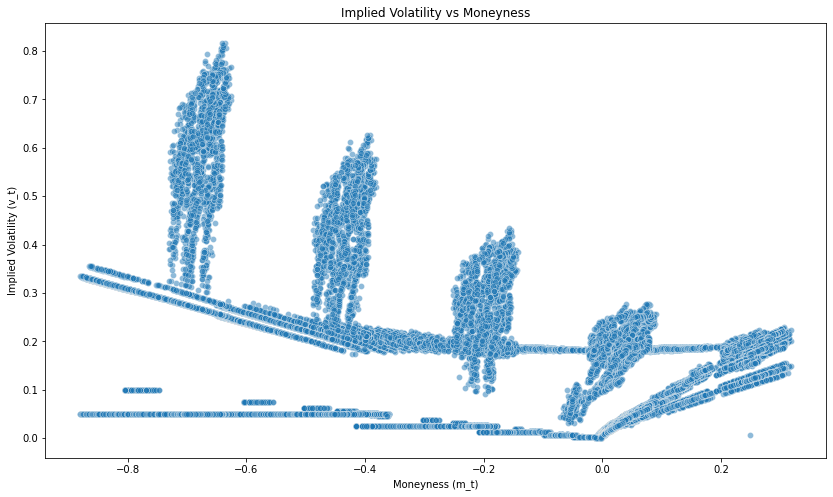

In [46]:
import seaborn as sns

def plot_implied_vola_moneyness(df):
    plt.figure(figsize=(14, 8))
    sns.scatterplot(data=df, x="m_t", y="v_t", alpha=0.5)
    plt.title("Implied Volatility vs Moneyness")
    plt.xlabel("Moneyness (m_t)")
    plt.ylabel("Implied Volatility (v_t)")
    
plot_implied_vola_moneyness(df_volc)
    

**With some imagination, you can see some sort of smile in the graph, but the whole thing just looks kinda bad. Probably due to outliers that should be removed. Not sure how to do that exactly though, we should then first define what an outlier is in this case.**

**Here is an alternative (read: lazy) idea**  
Someone posted the following on discord:
![Screenshot 2025-04-16 at 10.16.48.png](<attachment:Screenshot 2025-04-16 at 10.16.48.png>)
We can try to 'reverse engineer' the curve:

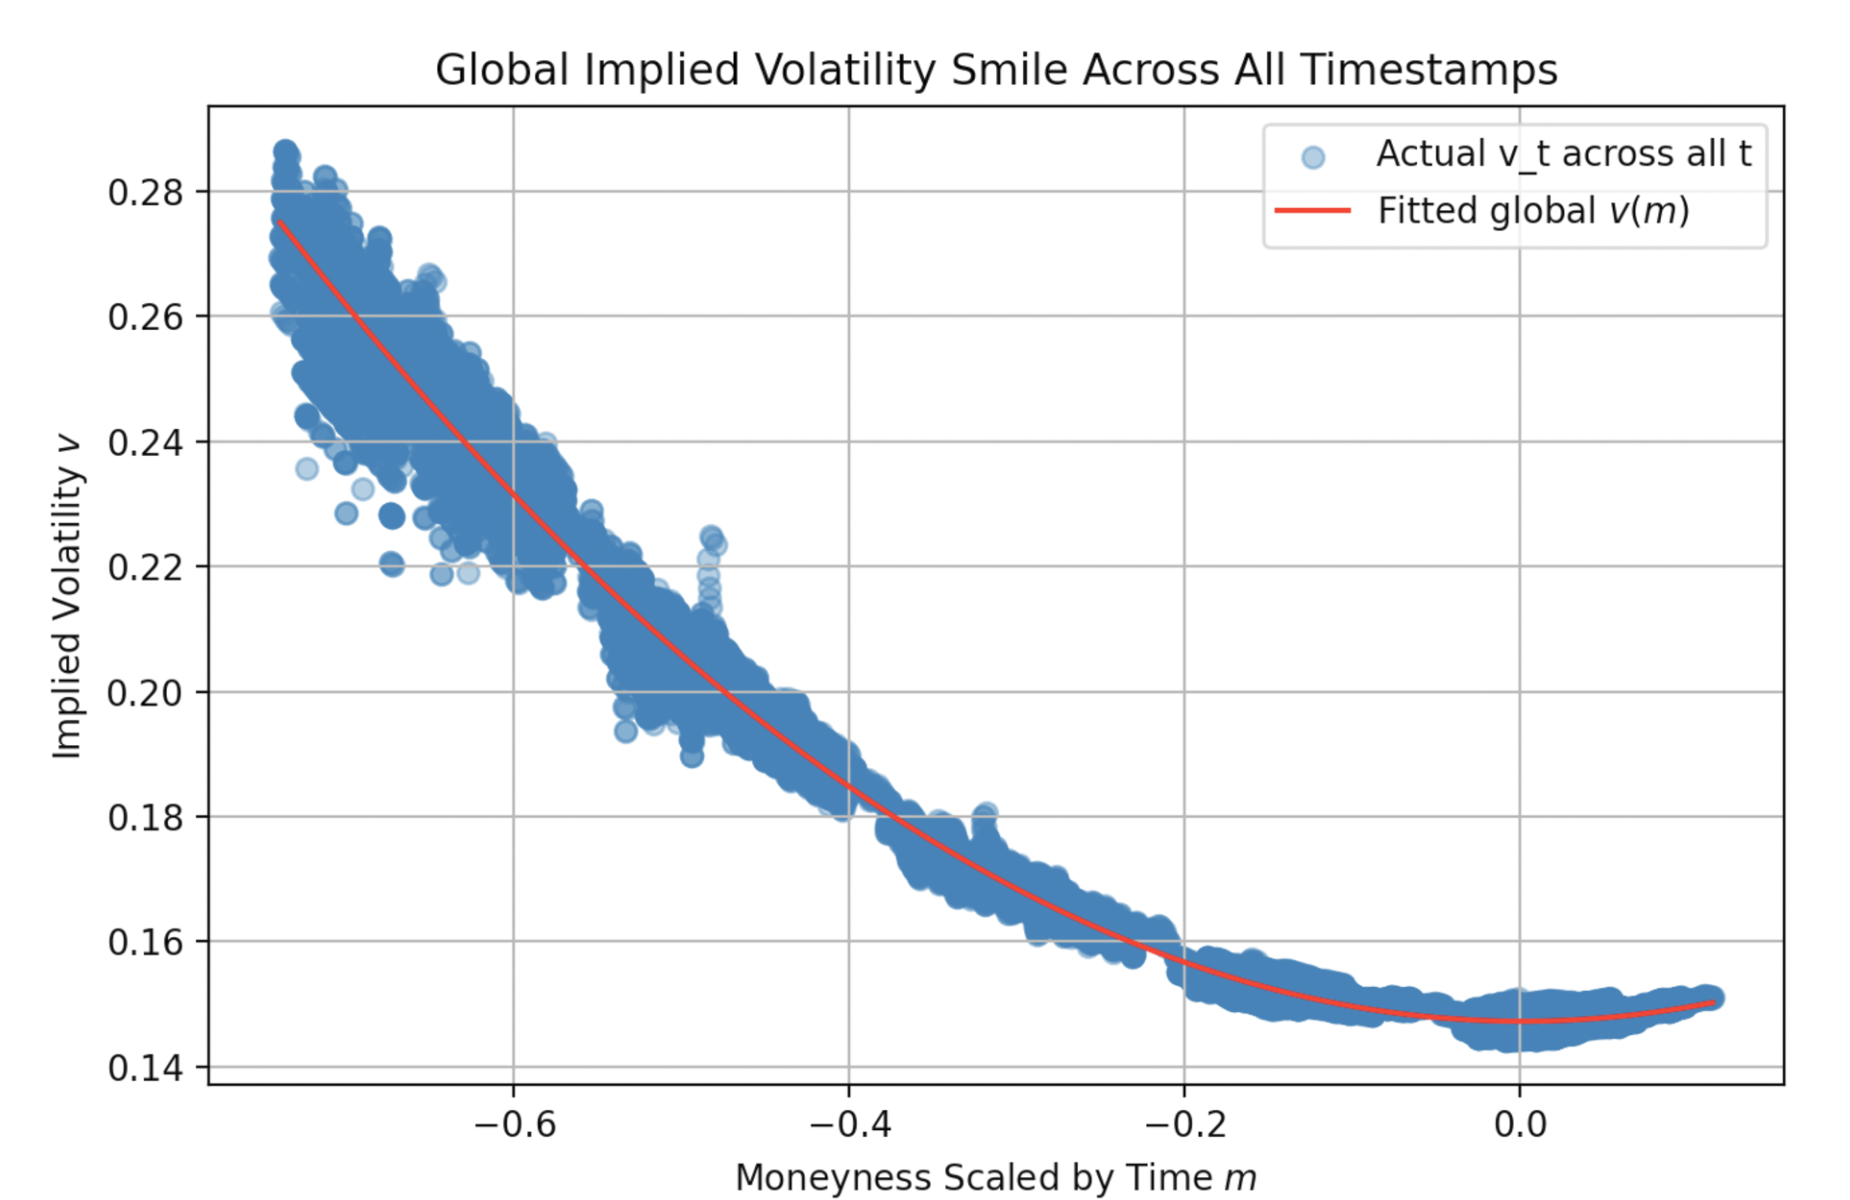

In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Data points I estimated from the image
x_points = np.array([-0.7, -0.6, -0.4, -0.3, -0.2, 0.0, 0.05])
y_points = np.array([0.26, 0.232, 0.185, 0.17, 0.158, 0.148, 0.15])

# Reshape for sklearn
X = x_points.reshape(-1, 1)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit polynomial regression
model = LinearRegression()
model.fit(X_poly, y_points)

# Get coefficients
a = model.coef_[2]  # x²
b = model.coef_[1]  # x
c = model.intercept_  # constant

print(f"a = {a:.4f}")
print(f"b = {b:.4f}")
print(f"c = {c:.4f}")

a = 0.2260
b = -0.0015
c = 0.1488


<ipython-input-48-24bceb0909b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['implied_vol'] = a * valid_data['m_t']**2 + b * valid_data['m_t'] + c


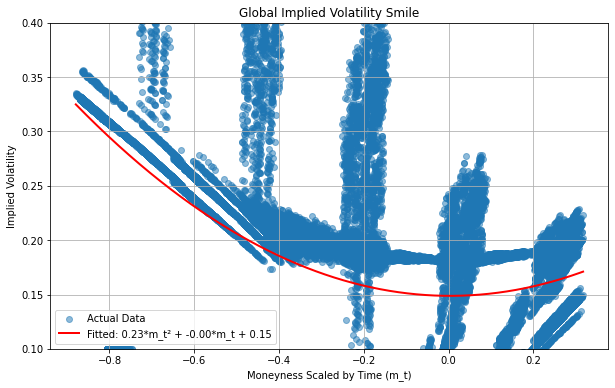

In [48]:
def plot_implied_volatility(df, a=0.2260, b=-0.0015, c=0.1488, show_scatter=True, figsize=(10, 6)):
    result_df = df.copy()
    plt.figure(figsize=figsize)
    
    # Filter out NaN values
    valid_data = result_df[result_df['m_t'].notna()]
    
    # Calculate v_t using our formula
    valid_data['implied_vol'] = a * valid_data['m_t']**2 + b * valid_data['m_t'] + c
    
    # Show scatter plot of original data if True
    if show_scatter and 'v_t' in valid_data.columns:
        plt.scatter(valid_data['m_t'], valid_data['v_t'], 
                   alpha=0.5, label='Actual Data')
    
    # plot curve
    plot_data = valid_data.sort_values('m_t')
    plt.plot(plot_data['m_t'], plot_data['implied_vol'], 'r-', 
             linewidth=2, label=f'Fitted: {a:.2f}*m_t² + {b:.2f}*m_t + {c:.2f}')
    plt.xlabel('Moneyness Scaled by Time (m_t)')
    plt.ylabel('Implied Volatility')
    plt.title('Global Implied Volatility Smile')
    plt.ylim(0.1,0.4) # adjusted ylim so that the curve is clearly visible
    plt.grid(True)
    plt.legend()
    
    return result_df

result = plot_implied_volatility(df_volc)

**Looks decent. Now we can use the coefficients for volatility arbitrage.**

In each tick, for each voucher:  
	1.	Calculate m_t = log(K/S) / sqrt(TTE)  
	2.	Use fitted parabola to get the “fair” implied volatility: v_model = fitted_vol(m_t)  
	3.	Use that volatility in the Black-Scholes model to compute the fair price of the voucher.  
	4.	Compare it to market mid-price.  
	5.	If the market price is way too high: sell the voucher. If way too low: buy it.  

Don't know how well this strategy works but it is worth a try I guess


In [ ]:
# a = 0.2260
# b = -0.0015
# c = 0.1488
def fitted_vol(m_t): 
    return 0.2260 * m_t**2 - 0.0015 * m_t + 0.1488

In [ ]:
# Recalculate v_t using fitted volatility function
df_volc["v_t"] = df_volc["m_t"].apply(fitted_vol)
df_volc.head(12)

,day,timestamp,product,mid_price,TTE,strike,mid_underlying,m_t,v_t
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.5,0.019178,10500.0,10503.0,-0.002063,0.148804
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.5,0.019178,10000.0,10503.0,-0.354377,0.177713
6,0,0,VOLCANIC_ROCK_VOUCHER_9750,754.5,0.019178,9750.0,10503.0,-0.537197,0.214825
9,0,0,VOLCANIC_ROCK_VOUCHER_9500,1003.5,0.019178,9500.0,10503.0,-0.724766,0.268602
11,0,0,VOLCANIC_ROCK_VOUCHER_10250,273.5,0.019178,10250.0,10503.0,-0.176071,0.156070
13,0,0,VOLCANIC_ROCK,10503.0,0.019178,NaN,10503.0,NaN,NaN
16,0,100,VOLCANIC_ROCK_VOUCHER_10000,515.5,0.019178,10000.0,10510.0,-0.359190,0.178497
19,0,100,VOLCANIC_ROCK_VOUCHER_10250,279.5,0.019178,10250.0,10510.0,-0.180884,0.156466
21,0,100,VOLCANIC_ROCK,10510.0,0.019178,NaN,10510.0,NaN,NaN
22,0,100,VOLCANIC_ROCK_VOUCHER_10500,102.5,0.019178,10500.0,10510.0,-0.006874,0.148821


**The following cells are used to come up with a threshold for each voucher to use in the Trader class**

In [49]:
# BS model call
def bs_call_price(S, K, T, vol):
    if S <= 0 or K <= 0 or T <= 0 or vol <= 0:
        return np.nan
    d1 = (np.log(S / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    from math import erf, sqrt, exp
    norm_cdf = lambda x: 0.5 * (1 + erf(x / sqrt(2)))
    return S * norm_cdf(d1) - K * norm_cdf(d2)

#  Compute fair price using fitted v_t 
df_volc["fair_price"] = df_volc.apply(
    lambda row: bs_call_price(row["mid_underlying"], row["strike"], row["TTE"], row["v_t"])
    if pd.notna(row["strike"]) else np.nan,
    axis=1
)

In [50]:
df_volc.head()

,day,timestamp,product,mid_price,TTE,strike,mid_underlying,m_t,v_t,fair_price
0,1,0,VOLCANIC_ROCK,10516.0,0.013699,NaN,10516.0,NaN,NaN,NaN
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1016.0,0.013699,9500.0,10516.0,-0.868123,0.050000,1016.000000
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.5,0.013699,9750.0,10516.0,-0.646188,0.252539,766.499188
7,1,0,VOLCANIC_ROCK_VOUCHER_10250,279.5,0.013699,10250.0,10516.0,-0.218899,0.186865,279.503243
9,1,0,VOLCANIC_ROCK_VOUCHER_10500,95.5,0.013699,10500.0,10516.0,-0.013010,0.177856,95.496398


In [51]:
df_volc["spread"] = df_volc["mid_price"] - df_volc["fair_price"]
thresholds_std = (
    df_volc[df_volc["strike"].notna()]
    .groupby("product")["spread"]
    .agg(["mean", "std"])
    .assign(threshold=lambda x: x["std"] * 2) # can x1.5, x2
)
print(thresholds_std)

                                   mean         std   threshold
product                                                        
VOLCANIC_ROCK_VOUCHER_10000 -143.936839  129.158648  258.317296
VOLCANIC_ROCK_VOUCHER_10250  -70.712879   77.658761  155.317521
VOLCANIC_ROCK_VOUCHER_10500   -0.046496    0.598512    1.197023
VOLCANIC_ROCK_VOUCHER_9500  -166.358612  148.384253  296.768505
VOLCANIC_ROCK_VOUCHER_9750  -164.139019  146.171534  292.343068


In [52]:
# this one is with percentiles
thresholds_pct = (
    df_volc[df_volc["strike"].notna()]
    .groupby("product")["spread"]
    .apply(lambda x: np.percentile(np.abs(x), 95))
    .rename("threshold_95p")
)
print(thresholds_pct)

product
VOLCANIC_ROCK_VOUCHER_10000    323.000000
VOLCANIC_ROCK_VOUCHER_10250    192.500000
VOLCANIC_ROCK_VOUCHER_10500      0.011342
VOLCANIC_ROCK_VOUCHER_9500     373.000000
VOLCANIC_ROCK_VOUCHER_9750     366.500000
Name: threshold_95p, dtype: float64


In [53]:
# Calculate error and z-score per voucher
df_volc["error"] = df_volc["fair_price"] - df_volc["mid_price"]

# Compute z-score of the error column grouped by product
df_volc["zscore_error"] = df_volc.groupby("product")["error"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Show z-score statistics per voucher
zscore_stats = df_volc.groupby("product")["zscore_error"].describe()
print(zscore_stats)

                               count          mean  std       min       25%  \
product                                                                       
VOLCANIC_ROCK                    0.0           NaN  NaN       NaN       NaN   
VOLCANIC_ROCK_VOUCHER_10000  30000.0 -1.364242e-16  1.0 -1.114567 -1.114407   
VOLCANIC_ROCK_VOUCHER_10250  30000.0 -8.337035e-17  1.0 -0.910835 -0.910556   
VOLCANIC_ROCK_VOUCHER_10500  30000.0  9.473903e-18  1.0 -0.117447 -0.083675   
VOLCANIC_ROCK_VOUCHER_9500   30000.0 -2.122154e-16  1.0 -1.121231 -1.121134   
VOLCANIC_ROCK_VOUCHER_9750   30000.0  3.031649e-17  1.0 -1.123025 -1.122918   

                                  50%       75%        max  
product                                                     
VOLCANIC_ROCK                     NaN       NaN        NaN  
VOLCANIC_ROCK_VOUCHER_10000  0.290830  0.921837   1.893510  
VOLCANIC_ROCK_VOUCHER_10250 -0.775352  0.956584   2.070431  
VOLCANIC_ROCK_VOUCHER_10500 -0.077557 -0.071623  26.655297  
V